In [22]:
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [23]:
# Utils
def make_random_bin(length):
		return "".join([str(random.randint(0, 1)) for i in range(length)])

def add_bin(a: str, b: str):
		ans = bin(int(a[::-1], 2) + int(b[::-1], 2))[2:]
		# Pad with zeros
		ans = "0" * (len(a) - len(ans)) + ans
		return ans[::-1]

def convert_decimal_to_normalized_binary(a: int, b: int):
	# Convert the numbers to binary
	num1 = bin(a)[2:]
	num2 = bin(b)[2:]

	# Pad the numbers with zeros so that they are of the same length
	if len(num1) > len(num2):
		num2 = "0" * (len(num1) - len(num2)) + num2
	elif len(num2) > len(num1):
		num1 = "0" * (len(num2) - len(num1)) + num1

	# Reverse the numbers
	num1 = num1[::-1] + "0"
	num2 = num2[::-1] + "0"

	return num1, num2

def convert_normalized_binary_to_decimal(bin: str):
	# Reverse the output
	bin = bin[::-1]

	# Convert the output to a number
	return int("".join(bin), 2)


Create the dataset

In [24]:
class BinaryDataset(Dataset):
	def __init__(self, seq_length, num_bits):
		self.seq_length = seq_length
		self.num_bits = num_bits
		self.seq1 = make_random_bin(seq_length)
		self.seq2 = make_random_bin(seq_length)

	def __getitem__(self, index):
		sample1 = self.seq1[index:index + self.num_bits - 1] + "0"
		sample2 = self.seq2[index:index + self.num_bits - 1] + "0"
		input = torch.tensor([[int(x, 2) for x in sample1], [int(x, 2) for x in sample2]])
		input = torch.transpose(input, 0, 1).float()
		output = torch.tensor([int(x, 2) for x in add_bin(sample1, sample2)])
		return input, output

	def __len__(self):
		return self.seq_length - self.num_bits + 1

In [25]:
data = BinaryDataset(3 * 128, 5)
test_dataloader = DataLoader(dataset=data, batch_size=128)
print(data.__getitem__(0))

(tensor([[0., 1.],
        [0., 1.],
        [0., 0.],
        [1., 0.],
        [0., 0.]]), tensor([1, 1, 0, 1, 0]))


In [26]:
# Define the model
class Model(nn.Module):
	def __init__(self) -> None:
		super().__init__()
		self.input_size = 2 # Passing two binary bits
		self.hidden_dim = 10
		self.output_size = 1 # Returning 1 bit binary sum

		self.rnn = nn.RNN(
			input_size=self.input_size,
			hidden_size=self.hidden_dim,
			batch_first=True
		)
		self.fc = nn.Linear(self.hidden_dim, self.output_size)
		self.sigmoid = nn.Sigmoid()

	def forward(self, x):
		# X is of shape (batch_size, sequence_length, input_dim = 2)
		out, _ = self.rnn(x)

		# out is shape (batch_size, sequence_length, hidden_dim = 10)

		out = self.fc(out)

		out = self.sigmoid(out)

		# out is now of shape (batch_size, sequence_length, output_dim = 1)

		# Transform output to size (batch_size, sequence_length)
		out = out.squeeze()

		return out

In [27]:
# Create the model
model = Model()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


# Test the model's accuracy
def compute_accuracy(label, pred):
	pred = torch.round(pred)
	# Pred is of size (batch_size, sequence_length)
	# Label is of size (batch_size, sequence_length)
	return torch.sum(label == pred).item() / (len(label) * len(label[0]))


# Try the model on random data
x, label = next(iter(test_dataloader))
out = model(x)
print(out.shape, label.shape)
print("Input", x[0])
print("Sum",  label[0])
print("Output", out[0])
print(compute_accuracy(label, out))


torch.Size([128, 5]) torch.Size([128, 5])
Input tensor([[0., 1.],
        [0., 1.],
        [0., 0.],
        [1., 0.],
        [0., 0.]])
Sum tensor([1, 1, 0, 1, 0])
Output tensor([0.5111, 0.4795, 0.5527, 0.6154, 0.5409], grad_fn=<SelectBackward0>)
0.4703125


In [28]:

# Train the model
num_epochs = 100

all_losses = []

best_loss = 10

for epoch in range(num_epochs):
	losses = []
	for x, label in iter(test_dataloader):
		model.train()

		# Forward pass
		out = model(x)
		loss = criterion(out, label.float())

		# Backward and optimize
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())

		# Compute accuracy
		accuracy = compute_accuracy(label, out)

		if loss.item() < best_loss:
			best_loss = loss.item()
			torch.save(model.state_dict(), "best-model.bin")

		print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.2f}%")
	
	avg_loss = sum(losses) / len(losses)
	all_losses.append(avg_loss)
	

Epoch [0/100], Loss: 0.7007, Accuracy: 47.03%
Epoch [0/100], Loss: 0.7376, Accuracy: 51.41%
Epoch [0/100], Loss: 0.6969, Accuracy: 47.10%
Epoch [1/100], Loss: 0.6934, Accuracy: 51.25%
Epoch [1/100], Loss: 0.6981, Accuracy: 49.22%
Epoch [1/100], Loss: 0.6916, Accuracy: 46.13%
Epoch [2/100], Loss: 0.7003, Accuracy: 48.75%
Epoch [2/100], Loss: 0.6894, Accuracy: 55.31%
Epoch [2/100], Loss: 0.6938, Accuracy: 54.35%
Epoch [3/100], Loss: 0.6963, Accuracy: 53.91%
Epoch [3/100], Loss: 0.6828, Accuracy: 49.06%
Epoch [3/100], Loss: 0.7065, Accuracy: 48.71%
Epoch [4/100], Loss: 0.6847, Accuracy: 54.22%
Epoch [4/100], Loss: 0.6751, Accuracy: 63.59%
Epoch [4/100], Loss: 0.6929, Accuracy: 47.90%
Epoch [5/100], Loss: 0.6846, Accuracy: 57.50%
Epoch [5/100], Loss: 0.6718, Accuracy: 60.00%
Epoch [5/100], Loss: 0.6947, Accuracy: 52.74%
Epoch [6/100], Loss: 0.6849, Accuracy: 53.28%
Epoch [6/100], Loss: 0.6652, Accuracy: 61.25%
Epoch [6/100], Loss: 0.6896, Accuracy: 59.68%
Epoch [7/100], Loss: 0.6788, Accur

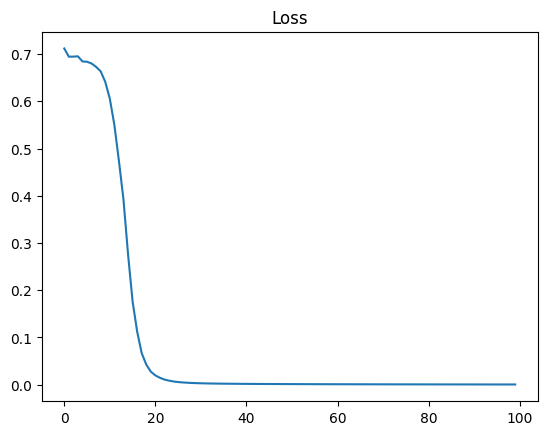

In [29]:
# Plot the losses

plt.title("Loss")
plt.plot(all_losses)

In [33]:
# Use the best model to add two user predicted numbers

model = Model()

model.load_state_dict(torch.load("best-model.bin"))

# Get two numbers from the user
n1 = int(input("Enter the first number: "))
n2 = int(input("Enter the second number: "))

input_sum = n1 + n2

# Convert sum to binary
sum_bin = bin(input_sum)[2:]

# reverse the sum
sum_bin = sum_bin[::-1]

b1, b2 = convert_decimal_to_normalized_binary(n1, n2)

print("Bin 1", b1, "Bin 2", b2)

numsT = torch.tensor([[int(x, 2) for x in b1], [int(x, 2) for x in b2]]).unsqueeze(0).float().transpose(1, 2)

out = model(numsT)

# round the output
out = torch.round(out)

# Convert the output to a string
out_bin = "".join([str(int(x)) for x in out])
out_deci = convert_normalized_binary_to_decimal(out_bin)


# Compute percent diff between the sum and the model's output
# By counting the number of digits correct
correct = 0
for i in range(len(sum_bin)):
    if sum_bin[i] == out_bin[i]:
        correct += 1
percent_correct = correct / len(sum_bin)

print(b1, "+", b2, "=", out_bin)

print(n1, "+", n2, "=", out_deci, "(", percent_correct * 100, "% correct)")

Bin 1 01111000 Bin 2 11011110
01111000 + 11011110 = 10011001
30 + 123 = 153 ( 100.0 % correct)


In [19]:
# This model memorizes

data = BinaryDataset(3 * 128, 5)
test_dataloader = DataLoader(dataset=data, batch_size=128)


# Make model 
# Define the model
class MemModel(nn.Module):
	def __init__(self) -> None:
		super().__init__()
		self.input_size = 2 # Passing two binary bits
		self.hidden_dim = 10
		self.output_size = 1 # Returning 1 bit binary sum
		
		self.rnn = nn.RNN(
			input_size=self.input_size,
			hidden_size=self.hidden_dim, 
			batch_first=True
		)
		self.fc = nn.Linear(self.hidden_dim, self.output_size)
		self.sigmoid = nn.Sigmoid()

	def forward(self, x):
		# hidden = self.init_hidden(batch_size)

		# X is of size (batch_size, sequence_length, input_dim = 2)
		# hidden is of size (n_layers, sequence_length, hidden_dim)
		out, hidden = self.rnn(x)

		out, _ = self.rnn(x, hidden)

		out = self.fc(out)

		out = self.sigmoid(out)

		# Out is now of shape (batch_size, sequence_length, output_dim = 1)

		out = out.squeeze()

		return out


# Create the model
model = MemModel()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


# Test the model's accuracy
def compute_accuracy(label, pred):
	pred = torch.round(pred)
	# Pred is of size (batch_size, sequence_length)
	# Label is of size (batch_size, sequence_length)
	return torch.sum(label == pred).item() / (len(label) * len(label[0]))


# Try the model on random data
x, label = next(iter(test_dataloader))
out = model(x)
print(out.shape, label.shape)
print("Input", x[0])
print("Sum",  label[0])
print("Output", out[0])
print(compute_accuracy(label, out))

# Train the model
num_epochs = 100

all_losses = []

best_loss = 10

for epoch in range(num_epochs):
	losses = []
	for x, label in iter(test_dataloader):
		model.train()

		# Forward pass
		out = model(x)
		loss = criterion(out, label.float())

		# Backward and optimize
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())

		# Compute accuracy
		accuracy = compute_accuracy(label, out)

		if loss.item() < best_loss:
			best_loss = loss.item()
			torch.save(model.state_dict(), "best-model-2.bin")

		print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.2f}%")
	
	avg_loss = sum(losses) / len(losses)
	all_losses.append(avg_loss)

torch.Size([128, 5]) torch.Size([128, 5])
Input tensor([[0., 1.],
        [0., 1.],
        [1., 1.],
        [0., 0.],
        [0., 0.]])
Sum tensor([1, 1, 0, 1, 0])
Output tensor([0.6085, 0.5913, 0.5762, 0.5631, 0.5631], grad_fn=<SelectBackward0>)
0.503125
Epoch [0/100], Loss: 0.7070, Accuracy: 50.31%
Epoch [0/100], Loss: 0.7555, Accuracy: 49.69%
Epoch [0/100], Loss: 0.6935, Accuracy: 52.26%
Epoch [1/100], Loss: 0.7176, Accuracy: 50.31%
Epoch [1/100], Loss: 0.6984, Accuracy: 51.25%
Epoch [1/100], Loss: 0.7008, Accuracy: 51.13%
Epoch [2/100], Loss: 0.6997, Accuracy: 48.59%
Epoch [2/100], Loss: 0.6924, Accuracy: 50.47%
Epoch [2/100], Loss: 0.6922, Accuracy: 51.61%
Epoch [3/100], Loss: 0.7007, Accuracy: 47.97%
Epoch [3/100], Loss: 0.6870, Accuracy: 53.91%
Epoch [3/100], Loss: 0.6945, Accuracy: 52.42%
Epoch [4/100], Loss: 0.6935, Accuracy: 49.53%
Epoch [4/100], Loss: 0.6899, Accuracy: 49.22%
Epoch [4/100], Loss: 0.6895, Accuracy: 52.10%
Epoch [5/100], Loss: 0.6875, Accuracy: 54.53%
Epoch